# P7_notebook Analyse Exploratoire - Implémentez un modèle de scoring

## Notebook parameters

In [1]:
# Library import
import os.path
import re
from collections import Counter
import gc
import string
import time
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, normalize
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from lightgbm import LGBMClassifier
import xgboost
import imblearn #Smote
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, roc_curve, ConfusionMatrixDisplay
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from joblib import dump, load

gc.enable()

In [2]:
# Uniformity of graphic colors
plt.rcParams['axes.facecolor'] = '#E6E6FA'

## Preparation of the compiled dataset

In [3]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns
gc.collect()

200

### application_train pretraitement


In [4]:
# Import data
application = pd.read_csv(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission', 'PretADepenser', 'application_train.csv'), sep=',')

gc.collect()

0

In [5]:
# First row vizualization
application.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# File size
print(application.shape)
gc.collect()

(307511, 122)


53

In [7]:
# Columns name list
print(application.columns.to_list())
gc.collect()

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELE

50

In [8]:
# Categorical features with Binary encode (0 or 1; two categories)
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        application[bin_feature], uniques = pd.factorize(
            application[bin_feature],sort = bool)
gc.collect()
application.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,1,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,0,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,1,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,0,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,1,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# List of the different categories for Code Gender
print(application['CODE_GENDER'].unique().tolist())
gc.collect()

[1, 0, 2]


50

In [10]:
# Exclusion of CODE_GENDER '2'  from the dataset
application = application[application['CODE_GENDER'] != 2]
gc.collect()

52

In [11]:
# List of the different categories for FLAG_OWN_CAR
print(application['FLAG_OWN_CAR'].unique().tolist())
gc.collect()

[0, 1]


50

In [12]:
# List of the different categories for FLAG_OWN_REALTY
print(application['FLAG_OWN_REALTY'].unique().tolist())
gc.collect()

[1, 0]


50

In [13]:
# Categorical features with One-Hot encode
application, categorical_columns = one_hot_encoder(application, True)
gc.collect()

0

In [14]:
# NaN values for DAYS_EMPLOYED: 365.243 -> nan
application['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

# Some simple new features (percentages)
application['DAYS_EMPLOYED_PERC'] = application['DAYS_EMPLOYED'] / application['DAYS_BIRTH']
application['INCOME_CREDIT_PERC'] = application['AMT_INCOME_TOTAL'] / application['AMT_CREDIT']
application['INCOME_PER_PERSON'] = application['AMT_INCOME_TOTAL'] / application['CNT_FAM_MEMBERS']
application['ANNUITY_INCOME_PERC'] = application['AMT_ANNUITY'] / application['AMT_INCOME_TOTAL']
application['PAYMENT_RATE'] = application['AMT_ANNUITY'] / application['AMT_CREDIT']
gc.collect()

50

In [15]:
# First row vizualization
application.head()
gc.collect()

50

### bureau & bureau_balance pretraitment

In [16]:
# Import data
bureau = pd.read_csv(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission', 'PretADepenser', 'bureau.csv'),
        sep=',')
bureau_bal = pd.read_csv(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission', 'PretADepenser', 'bureau_balance.csv'),
        sep=',')
gc.collect()

50

In [17]:
# First row vizualization
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [18]:
# First row vizualization
bureau_bal.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [19]:
# File size
print(bureau.shape)
gc.collect()

(1716428, 17)


153

In [20]:
# File size
print(bureau_bal.shape)
gc.collect()

(27299925, 3)


50

In [21]:
# Columns name list
print(bureau.columns.to_list())
gc.collect()

['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY']


50

In [22]:
# Columns name list
print(bureau_bal.columns.to_list())
gc.collect()

['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS']


50

In [23]:
# Categorical features with One-Hot encode
bureau_bal, bureau_bal_cat = one_hot_encoder(bureau_bal, True)
bureau, bureau_cat = one_hot_encoder(bureau, True)
gc.collect()


0

In [24]:
# Bureau balance: Perform aggregations and merge with bureau.csv
bureau_bal_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bureau_bal_cat:
    bureau_bal_aggregations[col] = ['mean']
bureau_bal_agg = bureau_bal.groupby('SK_ID_BUREAU').agg(bureau_bal_aggregations)
bureau_bal_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bureau_bal_agg.columns.tolist()])
bureau = bureau.join(bureau_bal_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
gc.collect()

0

In [25]:
# Bureau and bureau_balance numeric features
num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}
gc.collect()

50

In [26]:
# Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_cat: cat_aggregations[cat] = ['mean']
for cat in bureau_bal_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
gc.collect()

0

In [27]:
# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
gc.collect()

0

In [28]:
# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
gc.collect()

0

In [29]:
# Removal of non-useful variables
del bureau, bureau_bal, active_agg, active,closed, closed_agg
gc.collect()

50

In [30]:
# First row vizualization
bureau_agg.head()

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-51.0,0.0,35.0,140.0
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-47.0,0.0,15.0,90.0
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,0.0,13.0,13.0


### previous_application pretraitment

In [31]:
# Import data
previous_appli = pd.read_csv(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission', 'PretADepenser', 'previous_application.csv'),
        sep=',')
gc.collect()

50

In [32]:
# First row vizualization
previous_appli.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# File size
print(previous_appli.shape)
gc.collect()

(1670214, 37)


100

In [34]:
# Columns name list
print(previous_appli.columns.to_list())
gc.collect()

['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']


52

In [35]:
# Categorical features with One-Hot encode
previous_appli, previous_appli_cat = one_hot_encoder(previous_appli, True)
gc.collect()

0

In [36]:
# Days 365.243 values -> nan
previous_appli['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
previous_appli['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
previous_appli['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
previous_appli['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
previous_appli['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
gc.collect()

50

In [37]:
# Add feature: value ask / value received percentage
previous_appli['APP_CREDIT_PERC'] = previous_appli['AMT_APPLICATION'] / previous_appli['AMT_CREDIT']

# Previous applications numeric features
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
}
gc.collect()

63

In [38]:
# Previous applications categorical features
cat_aggregations = {}
for cat in previous_appli_cat:
    cat_aggregations[cat] = ['mean']

prev_agg = previous_appli.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
gc.collect()

0

In [39]:
# Previous Applications: Approved Applications - only numerical features
approved = previous_appli[previous_appli['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
gc.collect()

0

In [40]:
# Previous Applications: Refused Applications - only numerical features
refused = previous_appli[previous_appli['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
gc.collect()

0

In [41]:
# Removal of non-useful variables
del previous_appli, approved, approved_agg, refused, refused_agg
gc.collect()

50

In [42]:
# First row vizualization
prev_agg.head()

,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MIN,...,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3951.000,3951.000,3951.000,24835.5,24835.5,24835.50,23787.0,23787.0,23787.00,1.044079,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,9251.775,9251.775,9251.775,179055.0,179055.0,179055.00,179055.0,179055.0,179055.00,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,6737.310,98356.995,56553.990,68809.5,900000.0,435436.50,68053.5,1035882.0,484191.00,0.868825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,5357.250,5357.250,5357.250,24282.0,24282.0,24282.00,20106.0,20106.0,20106.00,1.207699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,4813.200,4813.200,4813.200,0.0,44617.5,22308.75,0.0,40153.5,20076.75,1.111173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### POS_CASH_balance pretraitment

In [43]:
# Import data
pos_cash = pd.read_csv(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission', 'PretADepenser', 'POS_CASH_balance.csv'),
        sep=',')
gc.collect()

50

In [44]:
# First row vizualization
pos_cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [45]:
# File size
print(pos_cash.shape)
gc.collect()

(10001358, 8)


100

In [46]:
# Columns name list
print(pos_cash.columns.to_list())
gc.collect()

['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF']


50

In [47]:
# Categorical features with One-Hot encode
pos_cash, pos_cash_cat = one_hot_encoder(pos_cash, True)
gc.collect()

50

In [48]:
 # Features
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
for cat in pos_cash_cat:
    aggregations[cat] = ['mean']

pos_agg = pos_cash.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
gc.collect()

0

In [49]:
# Count pos cash accounts
pos_agg['POS_COUNT'] = pos_cash.groupby('SK_ID_CURR').size()
del pos_cash
gc.collect()

50

In [50]:
# First row vizualization
pos_agg.head()

,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,
100001,-53,-72.555556,9,7,0.777778,7,0.777778,0.777778,0.0,0.0,0.0,0.222222,0.0,0.0,0.000000,0.0,0.0,9
100002,-1,-10.000000,19,0,0.000000,0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,19
100003,-18,-43.785714,28,0,0.000000,0,0.000000,0.928571,0.0,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0,0.0,28
100004,-24,-25.500000,4,0,0.000000,0,0.000000,0.750000,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0,0.0,4
100005,-15,-20.000000,11,0,0.000000,0,0.000000,0.818182,0.0,0.0,0.0,0.090909,0.0,0.0,0.090909,0.0,0.0,11


### installments_payments pretraitment

In [51]:
# Import data
installments_pay = pd.read_csv(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission', 'PretADepenser', 'installments_payments.csv'),
        sep=',')
gc.collect()

100

In [52]:
# First row vizualization
installments_pay.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [53]:
# File size
print(installments_pay.shape)
gc.collect()

(13605401, 8)


100

In [54]:
# Columns name list
print(installments_pay.columns.to_list())
gc.collect()

['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT']


50

In [55]:
# Categorical features with One-Hot encode
installments_pay, installments_pay_cat = one_hot_encoder(installments_pay, True)
gc.collect()

50

In [56]:
# Percentage and difference paid in each installment (amount paid and installment value)
installments_pay['PAYMENT_PERC'] = installments_pay['AMT_PAYMENT'] / installments_pay['AMT_INSTALMENT']
installments_pay['PAYMENT_DIFF'] = installments_pay['AMT_INSTALMENT'] - installments_pay['AMT_PAYMENT']
gc.collect()

63

In [57]:
# Days past due and days before due (no negative values)
installments_pay['DPD'] = installments_pay['DAYS_ENTRY_PAYMENT'] - installments_pay['DAYS_INSTALMENT']
installments_pay['DBD'] = installments_pay['DAYS_INSTALMENT'] - installments_pay['DAYS_ENTRY_PAYMENT']
installments_pay['DPD'] = installments_pay['DPD'].apply(lambda x: x if x > 0 else 0)
installments_pay['DBD'] = installments_pay['DBD'].apply(lambda x: x if x > 0 else 0)
gc.collect()

50

In [58]:
# Features: Perform aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean', 'sum'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
}
for cat in installments_pay_cat:
    aggregations[cat] = ['mean']
ins_agg = installments_pay.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
gc.collect()

0

In [59]:
 # Count installments accounts
ins_agg['INSTAL_COUNT'] = installments_pay.groupby('SK_ID_CURR').size()
del installments_pay
gc.collect()

50

In [60]:
# First row vizualization
ins_agg.head()

,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,2,11.0,1.571429,11.0,36.0,8.857143,62.0,1.0,1.0,7.0,...,5885.132143,41195.925,3951.000,17397.900,5885.132143,41195.925,-1628.0,-2195.000000,-15365.0,7
100002,2,0.0,0.000000,0.0,31.0,20.421053,388.0,1.0,1.0,19.0,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19
100003,2,0.0,0.000000,0.0,14.0,7.160000,179.0,1.0,1.0,25.0,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25
100004,2,0.0,0.000000,0.0,11.0,7.666667,23.0,1.0,1.0,3.0,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3
100005,2,1.0,0.111111,1.0,37.0,23.666667,213.0,1.0,1.0,9.0,...,6240.205000,56161.845,4813.200,17656.245,6240.205000,56161.845,-470.0,-609.555556,-5486.0,9


### credit_card-balance pretraitment

In [61]:
# Import data
credit_card = pd.read_csv(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission', 'PretADepenser', 'credit_card_balance.csv'),
        sep=',')
gc.collect()

0

In [62]:
# First row vizualization
credit_card.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [63]:
credit_card.shape
gc.collect()

100

In [64]:
# Columns name list
print(credit_card.columns.to_list())
gc.collect()

['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF']


50

In [65]:
# Categorical features with One-Hot encode
credit_card, credit_card_cat = one_hot_encoder(credit_card, True)
gc.collect()

0

In [66]:
 # General aggregations
credit_card.drop(['SK_ID_PREV'], axis= 1, inplace = True)
cc_agg = credit_card.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
gc.collect()

0

In [67]:
# Count credit card lines
cc_agg['CC_COUNT'] = credit_card.groupby('SK_ID_CURR').size()
del credit_card
gc.collect()

50

In [68]:
# First row vizualization
cc_agg.head()

,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-6,-1,-3.5,-21,3.5,0.0,0.00,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0.0,0,0.0,6
100011,-75,-2,-38.5,-2849,462.5,0.0,189000.00,54482.111149,4031676.225,4.641321e+09,...,0,0.0,0,0.0,0,0,0.0,0,0.0,74
100013,-96,-1,-48.5,-4656,776.0,0.0,161420.22,18159.919219,1743352.245,1.869473e+09,...,0,0.0,0,0.0,0,0,0.0,0,0.0,96
100021,-18,-2,-10.0,-170,25.5,0.0,0.00,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0.0,0,0.0,17
100023,-11,-4,-7.5,-60,6.0,0.0,0.00,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0.0,0,0.0,8


### Creation new dataset

In [69]:
# Join application & bureau_agg
application = application.join(bureau_agg, how='left', on='SK_ID_CURR')
del bureau_agg
gc.collect()

0

In [70]:
# Join application & prev_agg
application = application.join(prev_agg, how='left', on='SK_ID_CURR')
del prev_agg
gc.collect()

0

In [71]:
# Join application & pos_agg
application = application.join(pos_agg, how='left', on='SK_ID_CURR')
del pos_agg
gc.collect()

0

In [72]:
# Join application & ins_agg
application = application.join(ins_agg, how='left', on='SK_ID_CURR')
del ins_agg
gc.collect()

0

In [73]:
# Join application & cc_agg
application = application.join(cc_agg, how='left', on='SK_ID_CURR')
del cc_agg
gc.collect()

0

In [74]:
# First row vizualization
application.head()
gc.collect()

50

In [75]:
# Save to pickle the new Dataset
application.to_pickle(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission','application.pkl'))
del application, bureau_bal_agg, categorical_columns,previous_appli_cat, bureau_cat, bureau_bal_cat, credit_card_cat, pos_cash_cat
gc.collect()

0

## Exploratory analysis of the new dataset

In [3]:
# Import Dataset
application = pd.read_pickle(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission', 'application.pkl'))
gc.collect()

11

In [4]:
# First row vizualization
application.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# File size
print(application.shape)
gc.collect()

(307507, 810)


50

In [6]:
# File size for 'TARGET'=1 (Number of Individuals at risk of default --> individuals who did not get credit)
print(application[application['TARGET']==1].shape)
gc.collect()

(24825, 810)


0

In [7]:
# File size for 'TARGET'=0 (Number of Individuals with no risk of default --> individuals who got the credit)
print(application[application['TARGET']==0].shape)
gc.collect()

(282682, 810)


50

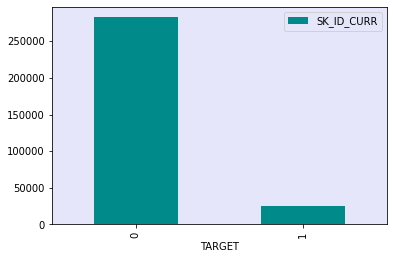

In [8]:
df_target = pd.pivot_table(
    data = application[['SK_ID_CURR','TARGET']],
    values = 'SK_ID_CURR',
    index = 'TARGET',
    aggfunc='count')
df_target.plot(kind = 'bar', color = "#008B8B")

In [9]:
# Dataset information
print(application.info())
gc.collect()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 0 to 307510
Columns: 810 entries, SK_ID_CURR to CC_COUNT
dtypes: float64(621), int64(43), uint8(146)
memory usage: 1.6 GB
None


0

In [10]:
# Count number of distinct elements in specified columns
application.nunique()

SK_ID_CURR                          307507
TARGET                                   2
CODE_GENDER                              2
FLAG_OWN_CAR                             2
FLAG_OWN_REALTY                          2
                                     ...  
CC_NAME_CONTRACT_STATUS_nan_MAX          1
CC_NAME_CONTRACT_STATUS_nan_MEAN         1
CC_NAME_CONTRACT_STATUS_nan_SUM          1
CC_NAME_CONTRACT_STATUS_nan_VAR          1
CC_COUNT                               128
Length: 810, dtype: int64

In [11]:
# Determine the bolean type variables and the non-significant variables
nunique_app = application.nunique().reset_index()
nunique_app = nunique_app[nunique_app[0] == 1]
no_signi_value = nunique_app['index'].tolist()
nunique_app = application.nunique().reset_index()
nunique_app = nunique_app[nunique_app[0] == 2]
bool_values = nunique_app['index'].tolist()
del nunique_app
gc.collect()

0

In [12]:
# Number of bolean type variables
len(bool_values)
gc.collect()

50

In [13]:
# Removal of columns of non-significant variables
application = application.drop(columns=no_signi_value)
del no_signi_value
gc.collect()

50

In [14]:
# Percentage of N/A
print(application.isna().mean())
gc.collect()

SK_ID_CURR                             0.000000
TARGET                                 0.000000
CODE_GENDER                            0.000000
FLAG_OWN_CAR                           0.000000
FLAG_OWN_REALTY                        0.000000
                                         ...   
CC_NAME_CONTRACT_STATUS_Signed_MAX     0.717389
CC_NAME_CONTRACT_STATUS_Signed_MEAN    0.717389
CC_NAME_CONTRACT_STATUS_Signed_SUM     0.717389
CC_NAME_CONTRACT_STATUS_Signed_VAR     0.719444
CC_COUNT                               0.717389
Length: 772, dtype: float64


50

In [15]:
# Statistical data dataset
application.describe(include='all')

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
count,307507.000000,307507.00000,307507.000000,307507.000000,307507.000000,307507.000000,3.075070e+05,3.075070e+05,307495.000000,3.072290e+05,...,86905.000000,86905.000000,86905.000000,86273.000000,86905.000000,86905.000000,86905.000000,86905.000000,86273.00000,86905.000000
mean,278181.527256,0.08073,0.341648,0.340106,0.693669,0.417047,1.687977e+05,5.990286e+05,27108.666786,5.383977e+05,...,0.005293,0.000064,0.005293,0.000064,0.000368,0.049376,0.003738,0.114366,0.00307,37.143605
std,102790.132982,0.27242,0.474263,0.473745,0.460970,0.722119,2.371246e+05,4.024926e+05,14493.798379,3.694472e+05,...,0.072562,0.000877,0.072562,0.000881,0.019186,0.216653,0.031882,1.323208,0.02036,33.698512
min,100002.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
25%,189146.500000,0.00000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,10.000000
50%,278203.000000,0.00000,0.000000,0.000000,1.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,22.000000
75%,367143.500000,0.00000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,75.000000
max,456255.000000,1.00000,1.000000,1.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,...,1.000000,0.024390,1.000000,0.024390,1.000000,1.000000,1.000000,62.000000,0.50000,192.000000


In [16]:
# List of quantitative variables
quanti = application.select_dtypes(include = ['float64']).columns.tolist()
gc.collect()

53

In [17]:
# Infiny value search (positive)
infiny = pd.DataFrame(application[quanti].max().sort_values()).reset_index()
infiny = infiny[infiny[0]==np.inf]
# List of columns containing infinite values
inf_columns = infiny["index"].tolist()
# Replace Infiny values
application[inf_columns] = application[inf_columns].replace(np.inf,application[application[inf_columns]!=np.inf].max())
del inf_columns
gc.collect()

0

In [18]:
# Infiny value search (negative)
application[quanti].min().sort_values()
gc.collect()

50

In [19]:
# Columns name list
columns = application.columns.to_list()
gc.collect()

50

In [20]:
# List of columns containing na value
na_columns = []
for c in columns:
    nan_row = application[c].isna().values.any()
    if nan_row == True:
        na_columns.append(c)
del columns, c, nan_row
# Number of columns containing na value
print(len(na_columns))
# Replace na values
simple_impute = SimpleImputer(missing_values=np.nan, strategy='median').fit(application[na_columns])
#application = application[columns].apply(lambda x:x.fillna(x.median()))
application[na_columns]=simple_impute.transform(application[na_columns])
del na_columns
gc.collect()

585


0

In [21]:
# Transform boolean values in integer
application[bool_values] = application[bool_values].astype('int')
del bool_values
gc.collect()

0

In [22]:
# Percentage of N/A
print(application.isna().mean())
gc.collect()

SK_ID_CURR                             0.0
TARGET                                 0.0
CODE_GENDER                            0.0
FLAG_OWN_CAR                           0.0
FLAG_OWN_REALTY                        0.0
                                      ... 
CC_NAME_CONTRACT_STATUS_Signed_MAX     0.0
CC_NAME_CONTRACT_STATUS_Signed_MEAN    0.0
CC_NAME_CONTRACT_STATUS_Signed_SUM     0.0
CC_NAME_CONTRACT_STATUS_Signed_VAR     0.0
CC_COUNT                               0.0
Length: 772, dtype: float64


0

In [23]:
# Statistical data dataset
application.describe(include='all')

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
count,307507.000000,307507.00000,307507.000000,307507.000000,307507.000000,307507.000000,3.075070e+05,3.075070e+05,307507.000000,3.075070e+05,...,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000
mean,278181.527256,0.08073,0.341648,0.340106,0.693669,0.417047,1.687977e+05,5.990286e+05,27108.580714,5.383178e+05,...,0.001496,0.000018,0.001496,0.000018,0.000104,0.013954,0.001056,0.032321,0.000861,26.279756
std,102790.132982,0.27242,0.474263,0.473745,0.460970,0.722119,2.371246e+05,4.024926e+05,14493.522125,3.692898e+05,...,0.038648,0.000467,0.038648,0.000467,0.010201,0.117301,0.017032,0.705313,0.010872,19.168276
min,100002.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,189146.500000,0.00000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000
50%,278203.000000,0.00000,0.000000,0.000000,1.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000
75%,367143.500000,0.00000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000
max,456255.000000,1.00000,1.000000,1.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,...,1.000000,0.024390,1.000000,0.024390,1.000000,1.000000,1.000000,62.000000,0.500000,192.000000


In [24]:
# Save to pickle the clean Dataset
application.to_pickle(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission','application.pkl'))
del application, quanti
gc.collect()

0

## Preparation of dataset for modelisation

In [3]:
# Import Dataset
application = pd.read_pickle(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission', 'application.pkl'))
gc.collect()

11

In [4]:
# Rename columns w/o special characters
application = application.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [5]:
# List of quantitatives variables
quanti = application.select_dtypes(include = ['float64']).columns.tolist()
# Normalization of quantitatives variables
application[quanti] = normalize(application[quanti])
gc.collect()

0

In [6]:
# Split data for Train_test split
X = application.drop(columns = ['SK_ID_CURR','TARGET'])
y = application['TARGET']
# Train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.60, random_state=0)
del X, y
gc.collect()

50

In [7]:
# File size for 'TARGET'=1 (Number of Individuals at risk of default --> individuals who did not get credit)
print(y_train[y_train == 1].shape)
gc.collect()

(9955,)


50

In [8]:
# File size for 'TARGET'=0 (Number of Individuals with no risk of default --> individuals who got the credit)
print(y_train[y_train == 0].shape)
gc.collect()

(113047,)


52

In [9]:
# Oversample imbalanced dataset with SMOTE
# Transform the training dataset
oversample = SMOTE(sampling_strategy=0.75)
X_train, y_train = oversample.fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y_train)
print(counter)
del counter
gc.collect()

Counter({0: 113047, 1: 84785})


0

In [10]:
# Save to pickle the Dataset
X_train.to_pickle(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission','application_X_train.pkl'))
y_train.to_pickle(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission','application_y_train.pkl'))
X_test.to_pickle(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission','application_X_test.pkl'))
y_test.to_pickle(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission','application_y_test.pkl'))
application.to_pickle(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission','application.pkl'))
del X_train, y_train, X_test, y_test, application, quanti
gc.collect()

0

## Modeling trials and scoring

### Modeling trials

In [3]:
# Import Data
X_train = pd.read_pickle(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission', 'application_X_train.pkl'))
y_train = pd.read_pickle(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission', 'application_y_train.pkl'))
X_test= pd.read_pickle(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission', 'application_X_test.pkl'))
y_test = pd.read_pickle(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission', 'application_y_test.pkl'))
gc.collect()

11

In [4]:
# Utilisation GridSearch pour déterminer meilleurs paramètres
# Logistic Regression
paramLr = {'penalty': ['l1', 'l2'], 'C': [1e-1, 1, 10]}
lr = LogisticRegression(solver = 'saga')

# Random Forest Regressor
paramForest = {"n_estimators": [100, 150, 200], "max_features": ["sqrt", "log2"]}
forest = RandomForestClassifier(class_weight = "balanced")

# LightGBM
paramLgbm = {"boosting_type": ["gbdt", "dart", "goss"]}
lgbm = lightgbm.LGBMClassifier(
    class_weight = {0:1, 1:1},
    is_unbalance = False, objective = 'binary')

# Xgboost
paramXgboost = {'booster': ['gbtree', 'gblinear', 'dart']}
x_gboost = xgboost.XGBClassifier()
gc.collect()

53

In [5]:
# Preparation model GridSearchCV and Logistic regression
gridLr = GridSearchCV(lr, paramLr, cv=2, scoring = 'roc_auc', error_score='raise')

# Preparation model GridSearchCV and Random Forest Regressor
gridForest = GridSearchCV(forest, paramForest, cv=2, scoring = 'roc_auc', error_score='raise')

# Preparation model GridSearchCV and LightGBM
gridLgbm = GridSearchCV(lgbm, paramLgbm, cv=2, scoring = 'roc_auc', error_score='raise')

# Preparation model GridSearchCV and Xgboost
gridXgboost = GridSearchCV(x_gboost, paramXgboost, cv=2, scoring = 'roc_auc', error_score='raise')
gc.collect()

50

In [6]:
# Application et calcul des scores avec les best param 

model={'Logistic Regression': gridLr,
              'Random Forest Classifier': gridForest,
              'Light GBM': gridLgbm,
              'Xgboost': gridXgboost}

# Création listes pour recap des valeurs des différents scores
mean_fit_time = []
mean_test_score = []
mean_score_time = []
best_score = []
y_predict = dict()
gc.collect()

50

In [7]:
# Logistic regression
# Fit modele
gridLr.fit(X_train, y_train)
# Calcul y_predict
y_predict['Logistic Regression'] = gridLr.best_estimator_.predict(X_test)
# Calcul Best Score
bestScore = gridLr.best_score_
best_score.append(bestScore)
# Calcul fit time
time = gridLr.cv_results_['mean_fit_time']
mean_fit_time.append(time)
# Calcul Mean_test_score
mts = gridLr.cv_results_['mean_test_score']
mean_test_score.append(mts)
# Calcul Mean_score_time
mst = gridLr.cv_results_['mean_score_time']
mean_score_time.append(mst)
gc.collect()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

288

In [8]:
# Random Forest Classifier 
# Fit modele
gridForest.fit(X_train, y_train)
# Calcul y_predict
y_predict['Random Forest Classifier'] = gridForest.best_estimator_.predict(X_test)
# Calcul Best Score
bestScore = gridForest.best_score_
best_score.append(bestScore)
# Calcul fit time
time = gridForest.cv_results_['mean_fit_time']
mean_fit_time.append(time)
# Calcul Mean_test_score
mts = gridForest.cv_results_['mean_test_score']
mean_test_score.append(mts)
# Calcul Mean_score_time
mst = gridForest.cv_results_['mean_score_time']
mean_score_time.append(mst)
gc.collect()

120

In [9]:
# Light GBM  
# Fit modele
gridLgbm.fit(X_train, y_train)
# Calcul y_predict
y_predict['Light GBM'] = gridLgbm.best_estimator_.predict(X_test)
# Calcul Best Score
bestScore = gridLgbm.best_score_
best_score.append(bestScore)
# Calcul fit time
time = gridLgbm.cv_results_['mean_fit_time']
mean_fit_time.append(time)
# Calcul Mean_test_score
mts = gridLgbm.cv_results_['mean_test_score']
mean_test_score.append(mts)
# Calcul Mean_score_time
mst = gridLgbm.cv_results_['mean_score_time']
mean_score_time.append(mst)
gc.collect()

60

In [10]:
# Xgboost   
# Fit modele
gridXgboost.fit(X_train, y_train)
# Calcul y_predict
y_predict['Xgboost'] = gridXgboost.best_estimator_.predict(X_test)
# Calcul Best Score
bestScore = gridXgboost.best_score_
best_score.append(bestScore)
# Calcul fit time
time = gridXgboost.cv_results_['mean_fit_time']
mean_fit_time.append(time)
# Calcul Mean_test_score
mts = gridXgboost.cv_results_['mean_test_score']
mean_test_score.append(mts)
# Calcul Mean_score_time
mst = gridXgboost.cv_results_['mean_score_time']
mean_score_time.append(mst)
gc.collect()

73

In [11]:
# DF recap result
result = {'best_score': best_score,'mean_fit_time': mean_fit_time,'mean_test_score': mean_test_score, 'mean_score_time': mean_score_time}
df = pd.DataFrame(data = result, index = model)
gc.collect()
df

,best_score,mean_fit_time,mean_test_score,mean_score_time
Logistic Regression,0.606477,"[138.77851378917694, 105.69967353343964, 138.3...","[0.6063951395306749, 0.60647699176658, 0.60645...","[0.4226773977279663, 0.40444397926330566, 0.44..."
Random Forest Classifier,0.963129,"[170.8256117105484, 255.96227169036865, 338.35...","[0.962317446228248, 0.9631290130037911, 0.9631...","[5.522206544876099, 7.646165490150452, 10.2828..."
Light GBM,0.955420,"[51.055973052978516, 51.44531738758087, 33.718...","[0.9553173141152924, 0.9554195624738826, 0.954...","[2.5404765605926514, 1.8154499530792236, 1.838..."
Xgboost,0.956286,"[297.8661370277405, 71.43992078304291, 307.964...","[0.9562863618354915, 0.8698724343115976, 0.956...","[2.28998863697052, 1.5249457359313965, 2.17283..."


In [12]:
gridLgbm.best_estimator_

LGBMClassifier(boosting_type='dart', class_weight={0: 1, 1: 1},
               is_unbalance=False, objective='binary')

In [13]:
gridLgbm.best_params_

{'boosting_type': 'dart'}

In [14]:
gridLgbm.best_score_

0.9554195624738826

In [15]:
# Save best ML mode
dump(gridLgbm.best_estimator_, os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission','lgbm_model.joblib'))
gc.collect()

159

In [16]:
gridForest.best_estimator_

RandomForestClassifier(class_weight='balanced', max_features='sqrt',
                       n_estimators=150)

In [17]:
gridForest.best_params_

{'max_features': 'sqrt', 'n_estimators': 150}

In [18]:
gridForest.best_score_

0.9631290130037911

In [19]:
# Save best ML mode
dump(gridForest.best_estimator_, os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission','forest_model.joblib'))
gc.collect()

0

### Bank cost score

#### With Light GBM

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


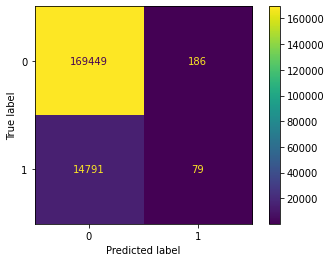

In [29]:
# Graphical confusion matrix
plot_confusion_matrix(gridLgbm.best_estimator_, X_test, y_test)  
plt.show()

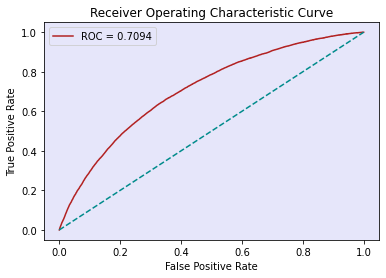

In [22]:
# Graphical ROC curve
def plot_roc_curve(fp, tp):
    plt.plot(fp, tp, color="#B22222", label='ROC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color="#008B8B", linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
y_pred_proba = gridLgbm.best_estimator_.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])
fp, tp, thresholds = roc_curve(y_test, y_pred_proba[:,1])
plot_roc_curve(fp, tp)

In [20]:
# Function to calculate the bank cost score

# True negative : predict not in default and really not in default
# True positive : predict in default and really in default
# False negative : predict not in default and really in default (financial losses)
# False positive : predict in default and really not in default (loss opportunities)

# I calculate a bank cost score for the bank, taking into account the fact
# that a defaulting customer costs more than an opportunity loss 

# I put a weight of 10 on the false negative

def cost_fct (y_test, y_pred):
    conf = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # tn = conf[0,0] ; fp = conf[0,1] ;fn = conf[1,0] ; tp = conf[1,1]     
    score = 10*fn + fp
    return score
gc.collect()

648

In [23]:
# Creation dataframe to find threshold where the score is the lowest
dic_score = {}
for p in np.arange(0.00, 1.00, 0.01):
    y_pred_proba = gridLgbm.best_estimator_.predict_proba(X_test)
    y_pred = np.where(y_pred_proba[:,1] < p, 0, 1)
    dic_score[round(p,2)] = cost_fct (y_test, y_pred)
df_score = pd.DataFrame(dic_score.items(), columns = ['threshold', 'score'])
gc.collect()

6566

4

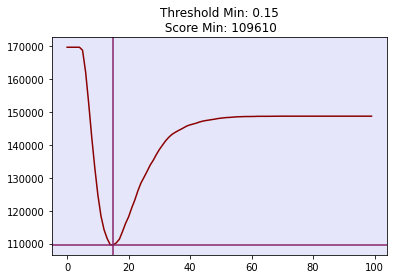

In [24]:
# Graphical representation of threshold
plt.plot(df_score['score'], c='#8b0000')
plt.axhline(y = df_score.at[np.argmin(df_score['score']),'score'] , color='#8a226a')
plt.axvline(x = df_score.at[np.argmin(df_score['score']),'threshold']*100 , color='#8a226a')
plt.title('Threshold Min: '+ str(df_score.at[np.argmin(df_score['score']),'threshold'])+
          '\n Score Min: '+ str(df_score.at[np.argmin(df_score['score']),'score']))
gc.collect()

In [26]:
threshold = df_score.at[np.argmin(df_score['score']),'threshold']

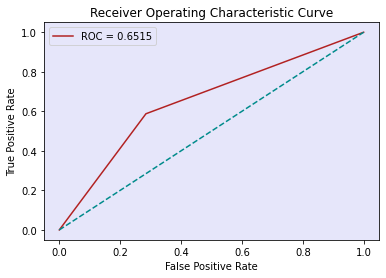

In [27]:
# Graphical ROC curve
def plot_roc_curve(fp, tp):
    plt.plot(fp, tp, color="#B22222", label='ROC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color="#008B8B", linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
roc_auc = roc_auc_score(y_test, np.where(y_pred_proba[:,1] < threshold, 0, 1))
fp, tp, thresholds = roc_curve(y_test, np.where(y_pred_proba[:,1] < threshold, 0, 1))
plot_roc_curve(fp, tp)

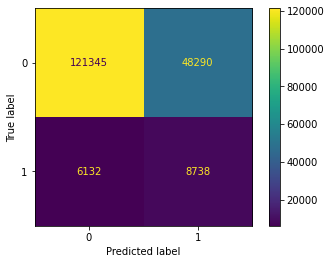

In [28]:
conf_threshold= confusion_matrix(y_test, np.where(y_pred_proba[:,1] < threshold, 0, 1))
disp = ConfusionMatrixDisplay(confusion_matrix = conf_threshold, display_labels=gridLgbm.best_estimator_.classes_)
disp.plot()

#### With Random Forest

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


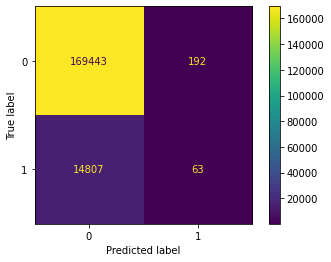

In [30]:
# Graphical confusion matrix
plot_confusion_matrix(gridForest.best_estimator_, X_test, y_test)  
plt.show()

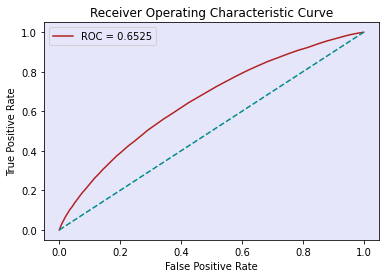

In [31]:
# Graphical ROC curve
def plot_roc_curve(fp, tp):
    plt.plot(fp, tp, color="#B22222", label='ROC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color="#008B8B", linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
y_pred_proba = gridForest.best_estimator_.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])
fp, tp, thresholds = roc_curve(y_test, y_pred_proba[:,1])
plot_roc_curve(fp, tp)

In [32]:
# Function to calculate the bank cost score

# True negative : predict not in default and really not in default
# True positive : predict in default and really in default
# False negative : predict not in default and really in default (financial losses)
# False positive : predict in default and really not in default (loss opportunities)

# I calculate a bank cost score for the bank, taking into account the fact
# that a defaulting customer costs more than an opportunity loss 

# I put a weight of 10 on the false negative

def cost_fct (y_test, y_pred):
    conf = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # tn = conf[0,0] ; fp = conf[0,1] ;fn = conf[1,0] ; tp = conf[1,1]     
    score = 10*fn + fp
    return score
gc.collect()

15501

In [33]:
# Creation dataframe to find threshold where the score is the lowest
dic_score = {}
for p in np.arange(0.00, 1.00, 0.01):
    y_pred_proba = gridForest.best_estimator_.predict_proba(X_test)
    y_pred = np.where(y_pred_proba[:,1] < p, 0, 1)
    dic_score[round(p,2)] = cost_fct (y_test, y_pred)
df_score = pd.DataFrame(dic_score.items(), columns = ['threshold', 'score'])
gc.collect()

48

4

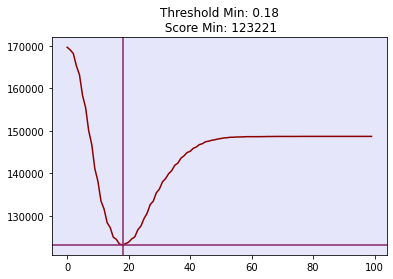

In [34]:
# Graphical representation of threshold
plt.plot(df_score['score'], c='#8b0000')
plt.axhline(y = df_score.at[np.argmin(df_score['score']),'score'] , color='#8a226a')
plt.axvline(x = df_score.at[np.argmin(df_score['score']),'threshold']*100 , color='#8a226a')
plt.title('Threshold Min: '+ str(df_score.at[np.argmin(df_score['score']),'threshold'])+
          '\n Score Min: '+ str(df_score.at[np.argmin(df_score['score']),'score']))
gc.collect()

In [35]:
threshold = df_score.at[np.argmin(df_score['score']),'threshold']

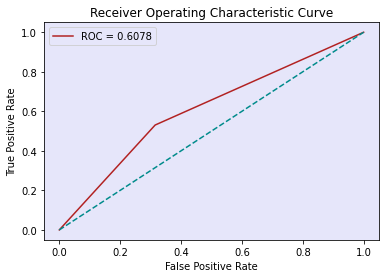

In [36]:
# Graphical ROC curve
def plot_roc_curve(fp, tp):
    plt.plot(fp, tp, color="#B22222", label='ROC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color="#008B8B", linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
roc_auc = roc_auc_score(y_test, np.where(y_pred_proba[:,1] < threshold, 0, 1))
fp, tp, thresholds = roc_curve(y_test, np.where(y_pred_proba[:,1] < threshold, 0, 1))
plot_roc_curve(fp, tp)

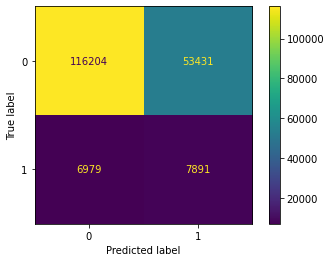

In [37]:
conf_threshold= confusion_matrix(y_test, np.where(y_pred_proba[:,1] < threshold, 0, 1))
disp = ConfusionMatrixDisplay(confusion_matrix = conf_threshold, display_labels=gridLgbm.best_estimator_.classes_)
disp.plot()

## Interpretability with SHAP

In [7]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.0 MB/s 


In [8]:
import shap
gc.collect()

0

In [26]:
# import data
X_test= pd.read_pickle(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission', 'application_X_test.pkl'))

gc.collect()

15

In [9]:
# import model
model = load(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission','lgbm_model.joblib'))
# compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
gc.collect()

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


12

In [28]:
model

LGBMClassifier(boosting_type='dart', class_weight={0: 1, 1: 1},
               is_unbalance=False, objective='binary')

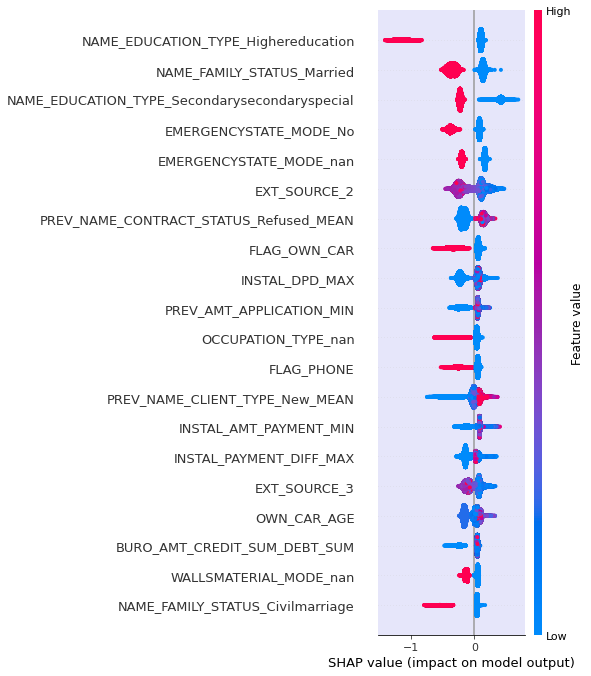

8966

In [29]:
# summary_plot 
# the 20 first variables explaination for individuals to obtain 1 (to be classified in risked)
shap.summary_plot(shap_values[1], X_test)
shap.initjs()
gc.collect()

In [30]:
# List of classes
model.classes_

array([0, 1])

In [31]:
# Probability for the first individu to obtain 0 or 1
model.predict_proba(X_test.head(1))

array([[0.90767703, 0.09232297]])

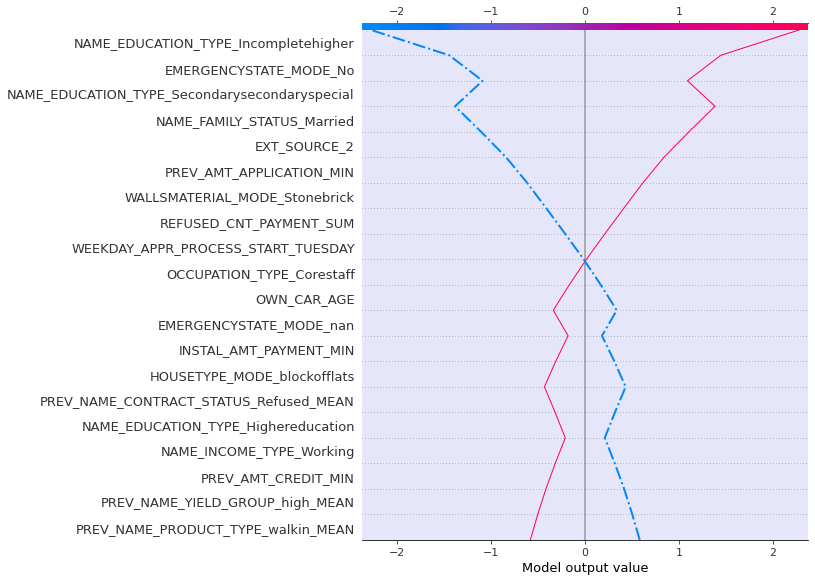

6164

In [32]:
# multioutput_decision_plot 
# the 20 variables explaination for the first individu to obtain 1 (to be classified in risked)
shap.multioutput_decision_plot(explainer.expected_value,
                               shap_values,
                               row_index=0,
                               feature_names=X_test.columns.tolist(),
                               highlight = [1]
                               )
shap.initjs()
gc.collect()

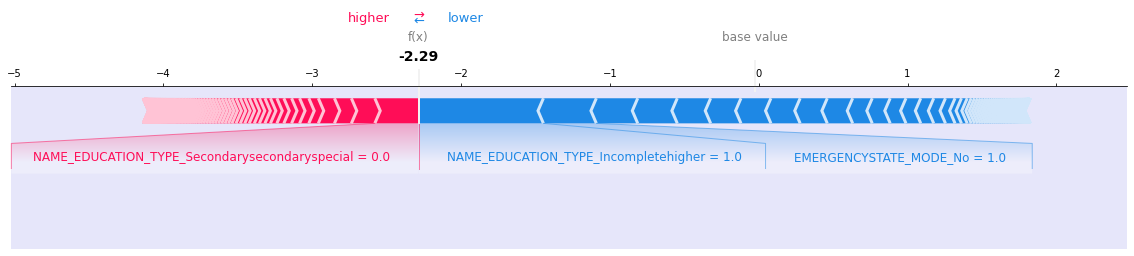

In [33]:
# Visualize the first prediction's explaination for expected value 1 (to be classified in risked)
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:],matplotlib=True)
shap.initjs()

In [34]:
# List of the 20 variables that influence the result 
feature_names = X_test.columns

rf_resultX = pd.DataFrame(shap_values[1], columns = feature_names)

vals = np.abs(rf_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shap_most_importance = shap_importance.head(20)
col_shap_most_importance = shap_most_importance['col_name'].tolist()
gc.collect()

31490

In [35]:
# dependence_plot for these 20 variables
for name in col_shap_most_importance:
    shap.dependence_plot(name, shap_values[1], X_test,)
    shap.initjs()
gc.collect()

Output hidden; open in https://colab.research.google.com to view.

## Functions

1.   Categorical columns encode
2.   Pretraitement & consolidation
3.   Non significative columns, N/A & Inf traitement
4.   Normalize numerical columns






In [ ]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns
gc.collect()

59

In [36]:
# Pretraitement & consolidation
def prepa_data(folder_path):
 # Import & traitement data application_train
    df = pd.read_csv(os.path.join(
        folder_path, 'application_train.csv'), sep=',')

    # Exclusion of CODE_GENDER 'XNA'  from the dataset
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(
            df[bin_feature],sort = bool)
    gc.collect()

    # Categorical features with One-Hot encode
    df, categorical_columns = one_hot_encoder(df, True)
    gc.collect()

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    gc.collect()

 # Import & traitement  data bureau & bureau_bal
    bureau = pd.read_csv(os.path.join(
        folder_path, 'bureau.csv'),sep=',')
    bureau_bal = pd.read_csv(os.path.join(
        folder_path, 'bureau_balance.csv'), sep=',')
    
    # Categorical features with One-Hot encode
    bureau_bal, bureau_bal_cat = one_hot_encoder(bureau_bal, True)
    bureau, bureau_cat = one_hot_encoder(bureau, True)
    gc.collect()

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bureau_bal_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bureau_bal_cat:
        bureau_bal_aggregations[col] = ['mean']
    bureau_bal_agg = bureau_bal.groupby('SK_ID_BUREAU').agg(bureau_bal_aggregations)
    bureau_bal_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bureau_bal_agg.columns.tolist()])
    bureau = bureau.join(bureau_bal_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
            'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
            'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
            'DAYS_CREDIT_UPDATE': ['mean'],
            'CREDIT_DAY_OVERDUE': ['max', 'mean'],
            'AMT_CREDIT_MAX_OVERDUE': ['mean'],
            'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
            'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
            'AMT_CREDIT_SUM_OVERDUE': ['mean'],
            'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
            'AMT_ANNUITY': ['max', 'mean'],
            'CNT_CREDIT_PROLONG': ['sum'],
            'MONTHS_BALANCE_MIN': ['min'],
            'MONTHS_BALANCE_MAX': ['max'],
            'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }

    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bureau_bal_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg(
        {**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(
        ['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    
    gc.collect()

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    
    gc.collect()

    # Join df & bureau_agg
    df = df.join(bureau_agg, how='left', on='SK_ID_CURR')

    # Removal of non-useful variables
    del bureau, bureau_bal, active_agg, active,closed, closed_agg, bureau_agg

 # Import & traitement  data previous_application
    previous_appli = pd.read_csv(os.path.join(
    folder_path, 'previous_application.csv'), sep=',')

    # Categorical features with One-Hot encode
    previous_appli, previous_appli_cat = one_hot_encoder(previous_appli, True)
    gc.collect()

    # Days 365.243 values -> nan
    previous_appli['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    previous_appli['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    previous_appli['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    previous_appli['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    previous_appli['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    gc.collect()

    # Add feature: value ask / value received percentage
    previous_appli['APP_CREDIT_PERC'] = previous_appli['AMT_APPLICATION'] / previous_appli['AMT_CREDIT']

    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }

    # Previous applications categorical features
    cat_aggregations = {}
    for cat in previous_appli_cat:
        cat_aggregations[cat] = ['mean']

    prev_agg = previous_appli.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    gc.collect()

    # Previous Applications: Approved Applications - only numerical features
    approved = previous_appli[previous_appli['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    gc.collect()

    # Previous Applications: Refused Applications - only numerical features
    refused = previous_appli[previous_appli['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    gc.collect()

    # Join df & prev_agg
    df = df.join(prev_agg, how='left', on='SK_ID_CURR')
    gc.collect()

    # Removal of non-useful variables
    del previous_appli, approved, approved_agg, refused, refused_agg, prev_agg
    gc.collect()

 # Import & traitement  data POS_CASH_balance
    pos_cash = pd.read_csv(os.path.join(
        folder_path, 'POS_CASH_balance.csv'), sep=',')

    # Categorical features with One-Hot encode
    pos_cash, pos_cash_cat = one_hot_encoder(pos_cash, True)
    gc.collect()

    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in pos_cash_cat:
        aggregations[cat] = ['mean']

    pos_agg = pos_cash.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    gc.collect()

    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos_cash.groupby('SK_ID_CURR').size()
    gc.collect()

    # Join df & pos_agg
    df = df.join(pos_agg, how='left', on='SK_ID_CURR')
    gc.collect()

    # Removal of non-useful variables
    del pos_cash, pos_agg
    gc.collect()

 # Import & traitement  data installments_payments
    installments_pay = pd.read_csv(os.path.join(
        folder_path, 'installments_payments.csv'), sep=',')
    
    # Categorical features with One-Hot encode
    installments_pay, installments_pay_cat = one_hot_encoder(installments_pay, True)
    gc.collect()

    # Percentage and difference paid in each installment (amount paid and installment value)
    installments_pay['PAYMENT_PERC'] = installments_pay['AMT_PAYMENT'] / installments_pay['AMT_INSTALMENT']
    installments_pay['PAYMENT_DIFF'] = installments_pay['AMT_INSTALMENT'] - installments_pay['AMT_PAYMENT']
    gc.collect()

    # Days past due and days before due (no negative values)
    installments_pay['DPD'] = installments_pay['DAYS_ENTRY_PAYMENT'] - installments_pay['DAYS_INSTALMENT']
    installments_pay['DBD'] = installments_pay['DAYS_INSTALMENT'] - installments_pay['DAYS_ENTRY_PAYMENT']
    installments_pay['DPD'] = installments_pay['DPD'].apply(lambda x: x if x > 0 else 0)
    installments_pay['DBD'] = installments_pay['DBD'].apply(lambda x: x if x > 0 else 0)
    gc.collect()

    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in installments_pay_cat:
        aggregations[cat] = ['mean']
    ins_agg = installments_pay.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    gc.collect()

    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = installments_pay.groupby('SK_ID_CURR').size()
    gc.collect()

    # Join df & ins_agg
    df = df.join(ins_agg, how='left', on='SK_ID_CURR')
    gc.collect()

    # Removal of non-useful variables
    del installments_pay, ins_agg

 # Import & traitement data credit_card_balance
    credit_card = pd.read_csv(os.path.join(
        folder_path, 'credit_card_balance.csv'),sep=',')
    gc.collect()

    # Categorical features with One-Hot encode
    credit_card, credit_card_cat = one_hot_encoder(credit_card, True)
    gc.collect()

    # General aggregations
    credit_card.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = credit_card.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    gc.collect()

    # Count credit card lines
    cc_agg['CC_COUNT'] = credit_card.groupby('SK_ID_CURR').size()
    gc.collect()

    # Join df & cc_agg
    df = df.join(cc_agg, how='left', on='SK_ID_CURR')
    gc.collect()

    # Removal of non-useful variables
    del credit_card, cc_agg

    # Rename columns w/o special characters
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    gc.collect() 
    
 # Return application file consolidated
    return df
gc.collect()

0

In [ ]:
# Non significative columns, N/A & Inf traitement
def clean_data(df):
    # Determine the bolean type variables and the non-significant variables
    nunique_app = df.nunique().reset_index()
    nunique_app = nunique_app[nunique_app[0] == 1]
    no_signi_value = nunique_app['index'].tolist()
    nunique_app = df.nunique().reset_index()
    nunique_app = nunique_app[nunique_app[0] == 2]
    bool_values = nunique_app['index'].tolist()
    del nunique_app
    gc.collect()

    # Removal of columns of non-significant variables
    df = df.drop(columns=no_signi_value)
    del no_signi_value
    gc.collect()

    # List of quantitative variables
    quanti =df.select_dtypes(include = ['float64']).columns.tolist()
    gc.collect()

    # Infiny value search (positive)
    infiny_pos = pd.DataFrame(df[quanti].max().sort_values()).reset_index()
    infiny_pos = infiny_pos[infiny_pos[0]==np.inf]
    # List of columns containing infinite values
    inf_columns = infiny_pos["index"].tolist()
    # Replace Infiny values
    df[inf_columns] = df[inf_columns].replace(np.inf, df[df[inf_columns]!=np.inf].max())
    del inf_columns, infiny_pos
    gc.collect()

    # Infiny value search (negative)
    infiny_neg = pd.DataFrame(df[quanti].min().sort_values()).reset_index()
    infiny_neg = infiny_neg[infiny_neg[0]==np.inf]
    # List of columns containing infinite values
    inf_columns = infiny_neg["index"].tolist()
    # Replace Infiny values
    df[inf_columns] = df[inf_columns].replace(np.inf, df[df[inf_columns]!=np.inf].min())
    del inf_columns, infiny_neg
    gc.collect()

    # Columns name list
    columns = df.columns.to_list()
    gc.collect()

    # List of columns containing na value
    na_columns = []
    for c in columns:
        nan_row = df[c].isna().values.any()
        if nan_row == True:
            na_columns.append(c)
    del columns, c, nan_row

    # Replace na values
    simple_impute = SimpleImputer(missing_values=np.nan, strategy='median').fit(df[na_columns])
    #df = df[columns].apply(lambda x:x.fillna(x.median()))
    df[na_columns]=simple_impute.transform(df[na_columns])
    del na_columns
    gc.collect()

    # Transform boolean values in integer
    df[bool_values] = df[bool_values].astype('int')
    del bool_values
    gc.collect()

    # Return df file cleaned
    return df
gc.collect()

0

In [ ]:
# Normalize numerical columns
def norm_data(df):
    # List of quantitatives variables
    quanti = df.select_dtypes(include = ['float64']).columns.tolist()
    # Normalization of quantitatives variables
    df[quanti] = normalize(df[quanti])
    gc.collect()

    # Return df file normalized
    return df
gc.collect()


50

### First pretraitement (apply three first function)

In [ ]:
folder_path = os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission', 'PretADepenser')
application = prepa_data(folder_path)
application = clean_data(application)

### Sampling data for API & Dashboard deployement

In [ ]:
sample = application.sample(frac =.001)

(308, 772)

In [ ]:
sample_norm = norm_data(sample)

In [ ]:
sample.to_pickle(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission','sample.pkl'))
sample_norm.to_csv(os.path.join(
        '/content', 'drive', 'MyDrive', 'Colab Notebooks', 'Projet7',
        '1-Mission','sample_norm.csv'))